In [27]:
%reset -f
import numpy as np
from landlab import RasterModelGrid
from landlab.components.overland_flow import OverlandFlow

#Mapping water depth
from landlab.plot.imshow import imshow_grid
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
colors = [(0,0,1,i) for i in np.linspace(0,1,3)]
WaterMap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

#Hillshading
from matplotlib.colors import LightSource

#Sediment Network Stuff
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot import plot_network_and_parcels
import warnings
warnings.filterwarnings('ignore')

#Sampling a raster - coordinate
def sampleRaster(raster,x,y):
    x = int(x)
    y = int(y)
    return raster[y,x]

def TopoToNodes():
    for i in range(nNodes):
        netZ[i] = sampleRaster(np.reshape(z,(nX,nY)),netGrid.node_x[i],netGrid.node_y[i])
    
def DepthToLinks():
    for i in range(nLinks):
        tempX = netGrid.nodes_at_link[i,0]
        tempY = netGrid.nodes_at_link[i,1]
        netH[i] = sampleRaster(np.reshape(h,(nX,nY)),netGrid.node_x[tempX],netGrid.node_y[tempY])


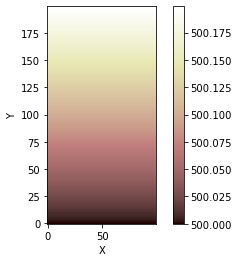

In [28]:
#Define grid
nX = 200
nY = 100
spacing = 1.0
grid = RasterModelGrid((nX, nY), xy_spacing=1.)

## Topography ##
Datum = 500 
z = np.ones(nX*nY) * Datum
z = grid.add_field('topographic__elevation', z, at='node')

# Long. slope
Long_Slope = 1./1000
z += grid.node_y*Long_Slope
imshow_grid(grid,'topographic__elevation')

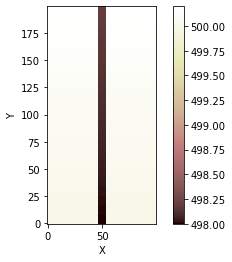

In [29]:
# Channel Indentation
Channel_Width = 8.
Channel_Depth = 2.

isChannel = (grid.node_x > (nY/2 - Channel_Width/2)) * (grid.node_x < (nY/2 + Channel_Width/2))

z[isChannel] -= Channel_Depth
imshow_grid(grid,'topographic__elevation')

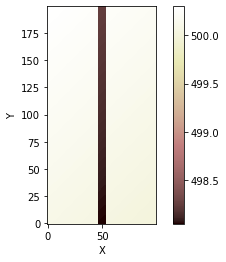

In [30]:
# Banks Slope
Transversal_Slope = 1./1000
z += np.abs(grid.node_x-(nX/2))*Transversal_Slope
imshow_grid(grid,'topographic__elevation')

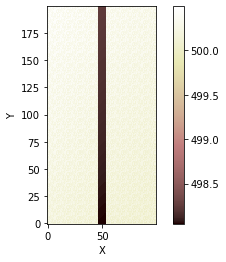

In [31]:
# Random noise
z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[int(nX/10),int(nY/10)]),nX*nY) 
imshow_grid(grid,'topographic__elevation')

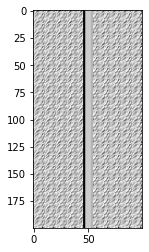

In [32]:
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray')
plt.show()

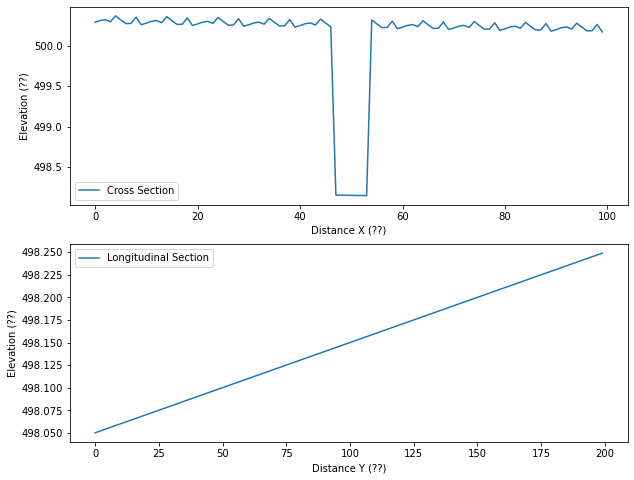

In [33]:
fig = plt.figure(figsize=(10,8))

## Cross Section
ax1 = plt.subplot(2,1,1)
ax1.plot(grid.node_x[grid.node_y==nX/2],z[grid.node_y==nX/2],label="Cross Section")
ax1.set_ylabel("Elevation (??)")
ax1.set_xlabel("Distance X (??)")
ax1.legend()

## Long Section
ax2 = plt.subplot(2,1,2)
ax2.plot(grid.node_y[grid.node_x==nY/2],z[grid.node_x==nY/2],label="Longitudinal Section")
ax2.set_ylabel("Elevation (??)")
ax2.set_xlabel("Distance Y (??)")
ax2.legend()

fig.show()

In [34]:
#Cast water depth values
#Pointer to water depth
h = np.zeros(nX*nY)
#bools = (grid.node_x > nX/2 - Channel_Width/2) * (grid.node_x < nX/2 + Channel_Width/2) * (grid.node_y >= 95)
bools = (grid.node_x > nY/2 - Channel_Width*2) * (grid.node_x < nY/2 + Channel_Width*2) * (grid.node_y >= nX-5)
h[bools] = Channel_Depth*1.1

#bools = (grid.node_x < 20) * (grid.node_y > 85) * (grid.node_y < 99)
#h[bools] = Channel_Depth*2
h = grid.add_field('surface_water__depth', h, at='node')

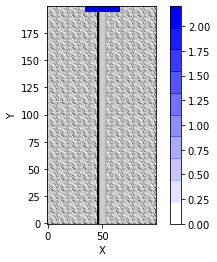

In [35]:
fig = plt.figure(figsize=(5,4))
plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
imshow_grid(grid,'surface_water__depth',cmap=WaterMap)
fig.show()

In [36]:
#Define a erosion network

#Topology
y_of_node = np.linspace(1,99,10)
x_of_node = np.ones_like(y_of_node)*nY/2
nNodes = len(x_of_node)

nodes_at_link = []

for i in range(nNodes-1):
    nodes_at_link.append((i,i+1))

print(nodes_at_link)

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]


[ 498.051  498.061  498.072  498.083  498.094  498.105  498.116  498.127
  498.138  498.149]


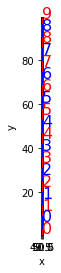

In [37]:
nLinks = len(nodes_at_link)

#Grid for sediment model
netGrid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

#Extract topograpy from raster and assign to nodes in the network
netZ = np.zeros(nNodes)
TopoToNodes()
netGrid.at_node["topographic__elevation"] = netZ
netGrid.at_node["bedrock__elevation"] = netZ - 0.5

#Print initial topographic elevation
print(netGrid.at_node["topographic__elevation"])

#Extract water depth from raster and assign it to nodes in the network
netH = np.zeros(nLinks)
DepthToLinks()
netGrid.at_link["flow_depth"] = netH

#Add other parameters :S
netGrid.at_link["reach_length"] = 50*np.ones(nLinks) # m
netGrid.at_link["channel_width"] = Channel_Width*np.ones(nLinks)

plt.figure(0)
graph.plot_graph(netGrid, at="node,link")
plt.show()

In [38]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(nLinks),30)
element_id = np.expand_dims(element_id, axis=1)

volume = 0.05*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.085 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In [39]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 
lithology = ["quartzite"] * np.size(element_id)

In [40]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

In [41]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    netGrid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

In [42]:
#Call flow routing
fd = FlowDirectorSteepest(netGrid, "topographic__elevation")
fd.run_one_step()

#Call sediment model
nst = NetworkSedimentTransporter(    
    netGrid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

In [43]:
#Call overland flow model
of = OverlandFlow(grid, steep_slopes=True)
of.run_one_step()

[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00

[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00

[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00

[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00000000e-08
   1.00000000e-08]
[  1.00000000e-08   1.00000000e-08   1.00000000e-08   1.00

KeyboardInterrupt: 

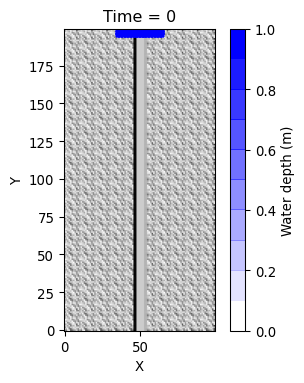

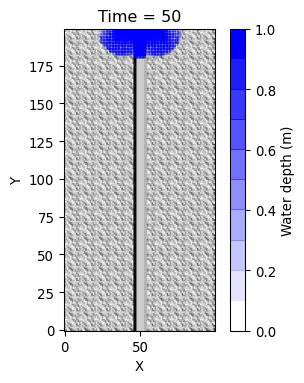

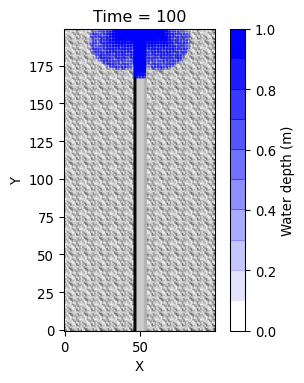

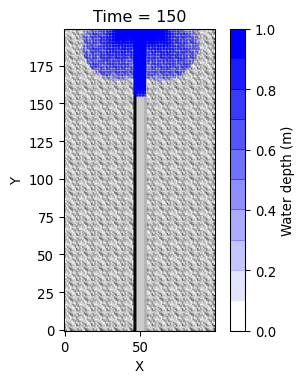

In [44]:
mydpi = 96
sizeFigure = 400

for t in range(2000):
    of.run_one_step()
    nst.run_one_step(of.dt)
    TopoToNodes()
    DepthToLinks()
    
    print(netGrid.at_link['flow_depth'])
    
    if t%50==0:
        fig = plt.figure(figsize=(sizeFigure/mydpi, sizeFigure/mydpi), dpi=mydpi)
        plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
        imshow_grid(grid,'surface_water__depth',\
                    limits=(0,1),cmap=WaterMap,\
                    colorbar_label="Water depth (m)",\
                    plot_name="Time = %i" %t)
        fig.savefig("ResultImages/" + str(t).zfill(5) + ".png")

In [ ]:
import imageio
from glob import glob

In [47]:
print(netGrid.at_link['flow_depth'][5])

1e-08


In [ ]:
images=[]
original_files=list(glob("./ResultImages/*.png"))
original_files.sort(reverse=False)
for file_ in original_files:
    images.append(imageio.imread(file_))
imageio.mimsave('./animation.gif', images, duration=1/5, subrectangles=True)

In [ ]:
print(netGrid.at_node["topographic__elevation"])

In [ ]:
print(netGrid.at_node)

In [ ]:
print(netGrid.at_link)

In [ ]:
print(netGrid.at_link['flow_depth'])

In [ ]:
plot_network_and_parcels(
    netGrid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    link_attribute="sediment_total_volume", 
    parcel_size=10, 
    parcel_alpha=1.0)